In [38]:
# Install xgboost using pip
!pip install xgboost
# Install shap using pip
!pip install shap

In [39]:
import shap
shap.initjs()

In [40]:
import pickle  # Import pickle for loading the model
import joblib  # Import joblib for loading the model
import pandas as pd
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import cross_val_score
import shap
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

In [41]:
warnings.filterwarnings("ignore")  # Getting rid of those pesky warnings
pd.set_option('display.max_columns', None) #Seeing all columns
%matplotlib inline

# Reading our dataset

In [42]:
import os
print(os.getcwd())
df = pd.read_csv(r'C:\Users\Admin\Documents\GitHub\Final_Project\CSVs\DB_with_skip_history.csv')
df

C:\Users\Admin\Documents\GitHub\Final_Project\Codes


,FROM_TIME,TO_TIME,COLOR,GENDER,SICK_FUND,SMS_SERVICE,patient_ID,AGE,APPOINTMENT_HOUR,APPOINTMENT_DAY,NO_SHOW,skip_history
0,2014-01-15 15:00:00,15/01/2014 15:40,8388736,1.0,חברת ביטוח,1,0.000000e+00,34,15,2,0,0
1,2014-01-15 15:00:00,15/01/2014 15:40,8388736,1.0,חברת ביטוח,1,0.000000e+00,67,15,2,0,0
2,2014-01-15 15:00:00,15/01/2014 15:40,8388736,NaN,חברת ביטוח,1,0.000000e+00,124,15,2,0,0
3,2014-01-15 15:00:00,15/01/2014 15:40,8388736,1.0,חברת ביטוח,1,0.000000e+00,124,15,2,0,0
4,2014-01-15 15:00:00,15/01/2014 15:40,8388736,NaN,חברת ביטוח,0,0.000000e+00,124,15,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100898,2023-04-27 10:00:00,27/04/2023 10:30,65535,1.0,כללית,1,1.111110e+15,124,10,3,0,0
100899,2023-05-03 15:00:00,03/05/2023 15:30,65535,1.0,כללית,1,1.111110e+15,124,15,2,0,0
100900,2023-05-15 13:00:00,15/05/2023 13:20,65535,1.0,כללית,1,1.111110e+15,124,13,0,0,0
100901,2023-05-29 13:00:00,29/05/2023 13:20,65535,1.0,כללית,1,1.111110e+15,124,13,0,0,0


# Re-arranging our dataframe, so that we only keep columns that would affect wether the patient showed up

In [43]:
# Columns we want to keep
columns_to_keep = ['FROM_TIME','TO_TIME', 'COLOR', 'AGE', 'GENDER', 'SICK_FUND', 'SMS_SERVICE', 'skip_history', 'NO_SHOW']

# Filter the DataFrame
df = df[columns_to_keep]

df.dropna()

,FROM_TIME,TO_TIME,COLOR,AGE,GENDER,SICK_FUND,SMS_SERVICE,skip_history,NO_SHOW
0,2014-01-15 15:00:00,15/01/2014 15:40,8388736,34,1.0,חברת ביטוח,1,0,0
1,2014-01-15 15:00:00,15/01/2014 15:40,8388736,67,1.0,חברת ביטוח,1,0,0
3,2014-01-15 15:00:00,15/01/2014 15:40,8388736,124,1.0,חברת ביטוח,1,0,0
5,2014-01-15 15:00:00,15/01/2014 15:40,8388736,124,0.0,חברת ביטוח,1,0,0
6,2014-01-15 15:00:00,15/01/2014 15:40,8388736,26,0.0,לאומית,0,0,0
...,...,...,...,...,...,...,...,...,...
100898,2023-04-27 10:00:00,27/04/2023 10:30,65535,124,1.0,כללית,1,0,0
100899,2023-05-03 15:00:00,03/05/2023 15:30,65535,124,1.0,כללית,1,0,0
100900,2023-05-15 13:00:00,15/05/2023 13:20,65535,124,1.0,כללית,1,0,0
100901,2023-05-29 13:00:00,29/05/2023 13:20,65535,124,1.0,כללית,1,0,0


# Inspect the Data:

In [44]:
df.info()  # Summary of the dataset
df.describe()  # Statistical summary
df.isnull().sum() # Check total nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100903 entries, 0 to 100902
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FROM_TIME     100903 non-null  object 
 1   TO_TIME       100903 non-null  object 
 2   COLOR         100903 non-null  int64  
 3   AGE           100903 non-null  int64  
 4   GENDER        72718 non-null   float64
 5   SICK_FUND     100903 non-null  object 
 6   SMS_SERVICE   100903 non-null  int64  
 7   skip_history  100903 non-null  int64  
 8   NO_SHOW       100903 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


FROM_TIME           0
TO_TIME             0
COLOR               0
AGE                 0
GENDER          28185
SICK_FUND           0
SMS_SERVICE         0
skip_history        0
NO_SHOW             0
dtype: int64

# Function to replace '16777215' in the COLOR column with a random other value

In [45]:
# Function to replace '16777215' with a random other value from the 'COLOR' column
def replace_color(df, color_column='COLOR', replace_value=16777215):
    # Get all unique values in the color column except the replace_value
    unique_colors = df[color_column].unique()
    unique_colors = unique_colors[unique_colors != replace_value]
    
    # Find indices where the color is the replace_value
    indices_to_replace = df[df[color_column] == replace_value].index
    
    # Replace each occurrence of the replace_value with a random choice from unique_colors
    for idx in indices_to_replace:
        df.at[idx, color_column] = np.random.choice(unique_colors)

# Apply the function to your DataFrame
replace_color(df)

# Now proceed with your model training and evaluation steps


# Re-Engineering our columns

In [46]:
# Convert columns to appropriate data types
df['FROM_TIME'] = pd.to_datetime(df['FROM_TIME'])
df['TO_TIME'] = pd.to_datetime(df['TO_TIME'])


df['APPOINTMENT_HOUR'] = df['FROM_TIME'].dt.hour
df['APPOINTMENT_DAY'] = df['FROM_TIME'].dt.dayofweek

# Calculate meeting length in minutes
df['meeting_length'] = (df['TO_TIME'] - df['FROM_TIME']).dt.total_seconds() / 60

df

,FROM_TIME,TO_TIME,COLOR,AGE,GENDER,SICK_FUND,SMS_SERVICE,skip_history,NO_SHOW,APPOINTMENT_HOUR,APPOINTMENT_DAY,meeting_length
0,2014-01-15 15:00:00,2014-01-15 15:40:00,8388736,34,1.0,חברת ביטוח,1,0,0,15,2,40.0
1,2014-01-15 15:00:00,2014-01-15 15:40:00,8388736,67,1.0,חברת ביטוח,1,0,0,15,2,40.0
2,2014-01-15 15:00:00,2014-01-15 15:40:00,8388736,124,NaN,חברת ביטוח,1,0,0,15,2,40.0
3,2014-01-15 15:00:00,2014-01-15 15:40:00,8388736,124,1.0,חברת ביטוח,1,0,0,15,2,40.0
4,2014-01-15 15:00:00,2014-01-15 15:40:00,8388736,124,NaN,חברת ביטוח,0,0,0,15,2,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100898,2023-04-27 10:00:00,2023-04-27 10:30:00,65535,124,1.0,כללית,1,0,0,10,3,30.0
100899,2023-05-03 15:00:00,2023-05-03 15:30:00,65535,124,1.0,כללית,1,0,0,15,2,30.0
100900,2023-05-15 13:00:00,2023-05-15 13:20:00,65535,124,1.0,כללית,1,0,0,13,0,20.0
100901,2023-05-29 13:00:00,2023-05-29 13:20:00,65535,124,1.0,כללית,1,0,0,13,0,20.0


# Age, day and time intervals

In [47]:
# Age intervals
bins = [0, 18, 30, 45, 60, 75, 90, 120]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

# Create hourly bins
bins = list(range(0, 25))  # 0-24 hours, inclusive
labels = [f'{i:02d}' for i in range(24)]  # Labels for each hour

df['PART_OF_DAY'] = pd.cut(df['APPOINTMENT_HOUR'], bins=bins, labels=labels, right=False)

# Define bins and labels for meeting length intervals
bins = [-float('inf'), 15, 20, 30, 40, 50, 60, float('inf')]
labels = ['< 15', '15-20', '20-30', '30-40', '40-50', '50-60', '> 60']

# Categorize meeting length into intervals
df['meeting_length_interval'] = pd.cut(df['meeting_length'], bins=bins, labels=labels)


# Map numerical day values to day names
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DAY_OF_WEEK'] = df['APPOINTMENT_DAY'].map(day_map)


# Drop unnecessary columns
df = df.drop(columns=['AGE', 'APPOINTMENT_DAY', 'APPOINTMENT_HOUR', 'FROM_TIME', 'TO_TIME', 'meeting_length'])

df = df.dropna()

In [48]:
def engineer_columns(df):
    try:
        # Step 1: Convert columns to appropriate data types
        df['FROM_TIME'] = pd.to_datetime(df['FROM_TIME'])
        df['TO_TIME'] = pd.to_datetime(df['TO_TIME'])

        df['APPOINTMENT_HOUR'] = df['FROM_TIME'].dt.hour
        df['APPOINTMENT_DAY'] = df['FROM_TIME'].dt.dayofweek

        # Calculate meeting length in minutes
        df['meeting_length'] = (df['TO_TIME'] - df['FROM_TIME']).dt.total_seconds() / 60

        # Step 2: Calculate skip history
        df['skip_history'] = 0

        # Sort DataFrame by patient_ID and FROM_TIME
        df = df.sort_values(by=['patient_ID', 'FROM_TIME'])

        # Calculate skip history
        for idx, row in df.iterrows():
            patient_id = row['patient_ID']
            current_time = row['FROM_TIME']

            # Count previous no-shows for the same patient
            previous_no_shows = df[(df['patient_ID'] == patient_id) &
                                   (df['FROM_TIME'] < current_time) &
                                   (df['NO_SHOW'] == 1)].shape[0]

            df.at[idx, 'skip_history'] = previous_no_shows

        # Step 3: Age intervals
        bins = [0, 18, 30, 45, 60, 75, 90, 120]
        labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+']
        df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

        # Create hourly bins
        bins = list(range(0, 25))  # 0-24 hours, inclusive
        labels = [f'{i:02d}' for i in range(24)]  # Labels for each hour
        df['PART_OF_DAY'] = pd.cut(df['APPOINTMENT_HOUR'], bins=bins, labels=labels, right=False)

        # Define bins and labels for meeting length intervals
        bins = [-float('inf'), 15, 20, 30, 40, 50, 60, float('inf')]
        labels = ['< 15', '15-20', '20-30', '30-40', '40-50', '50-60', '> 60']
        df['meeting_length_interval'] = pd.cut(df['meeting_length'], bins=bins, labels=labels)

        # Map numerical day values to day names
        day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
        df['DAY_OF_WEEK'] = df['APPOINTMENT_DAY'].map(day_map)

        # Drop unnecessary columns
        df = df.drop(columns=['AGE', 'APPOINTMENT_DAY', 'APPOINTMENT_HOUR', 'FROM_TIME', 'TO_TIME', 'meeting_length'])

        # Drop rows with missing values
        df = df.dropna()

    except KeyError as e:
        print(f"KeyError: {e}. Check column names and ensure they exist in the DataFrame.")

    except Exception as e:
        print(f"Error: {e}")

    return df

# Usage example
# df = pd.read_csv('your_file.csv')  # Load your DataFrame
df = engineer_columns(df)
print(df.head())


KeyError: 'FROM_TIME'. Check column names and ensure they exist in the DataFrame.
     COLOR  GENDER   SICK_FUND  SMS_SERVICE  skip_history  NO_SHOW AGE_GROUP  \
0  8388736     1.0  חברת ביטוח            1             0        0     31-45   
1  8388736     1.0  חברת ביטוח            1             0        0     61-75   
6  8388736     0.0      לאומית            0             0        0     19-30   
8    65535     1.0  חברת ביטוח            1             0        0     31-45   
9    65535     1.0  חברת ביטוח            1             0        0     61-75   

  PART_OF_DAY meeting_length_interval DAY_OF_WEEK  
0          15                   30-40   Wednesday  
1          15                   30-40   Wednesday  
6          15                   30-40   Wednesday  
8          18                   50-60      Sunday  
9          18                   50-60      Sunday  


# Visualize Distributions

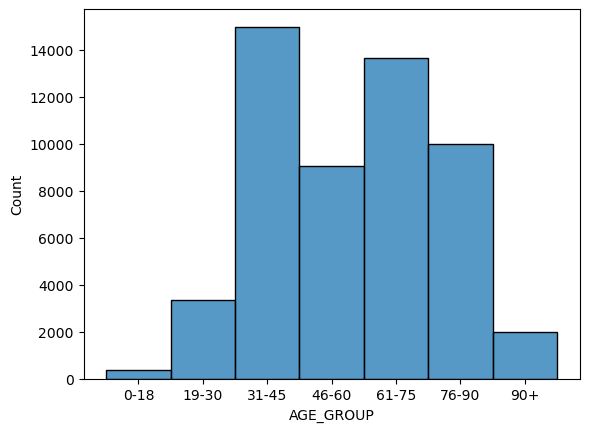

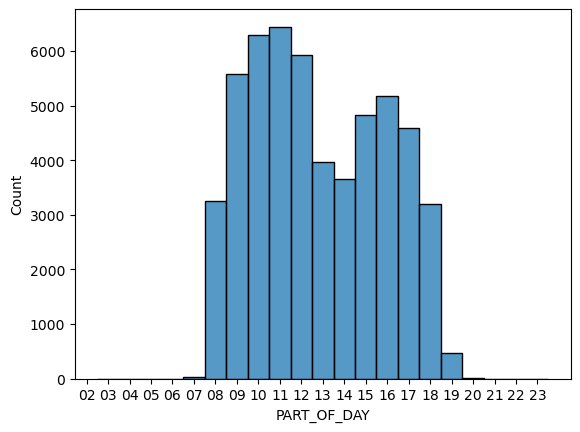

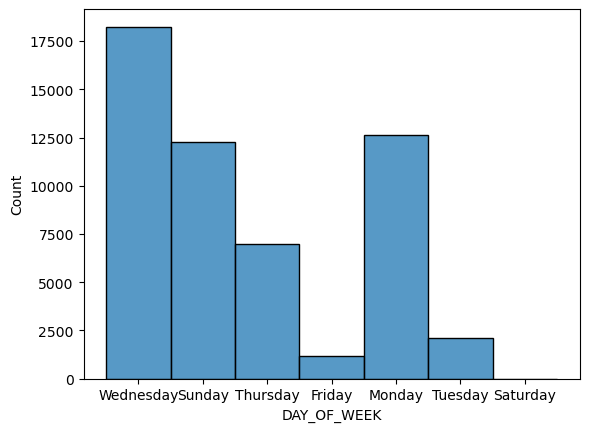

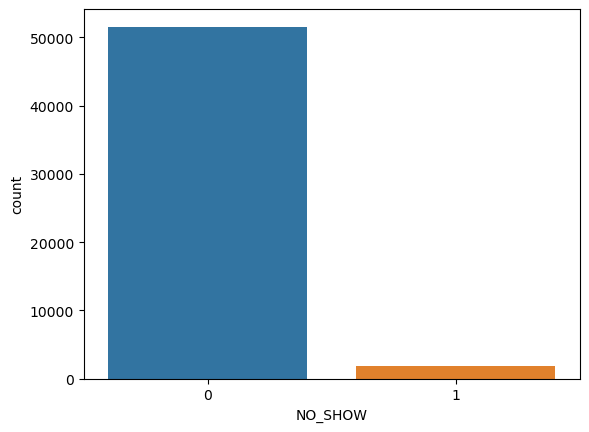

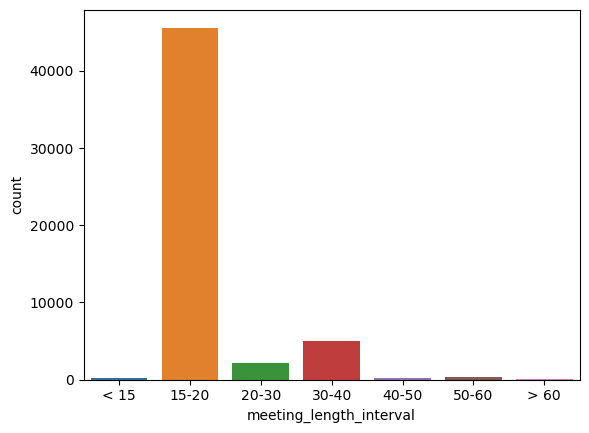

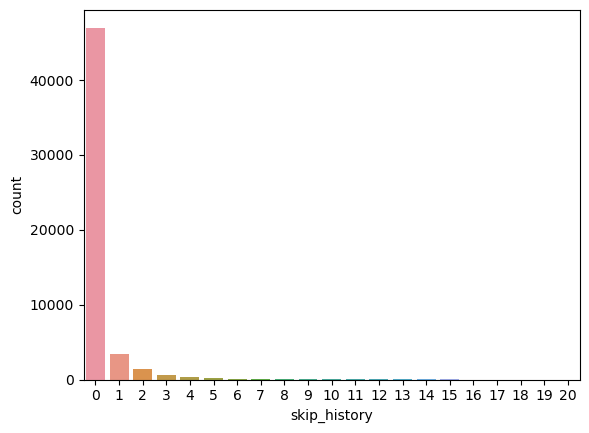

In [49]:
# Distribution of Age
sns.histplot(df['AGE_GROUP'])
plt.show()

# Distribution of appoitment time
sns.histplot(df['PART_OF_DAY'])
plt.show()


# Distribution of appoitment day
sns.histplot(df['DAY_OF_WEEK'])
plt.show()

# Distribution of No-Show
sns.countplot(x='NO_SHOW', data =df)
plt.show()


# Distribution of meeting length
sns.countplot(x='meeting_length_interval', data=df)
plt.show()

# Distribution of meeting length
sns.countplot(x='skip_history', data=df)
plt.show()

# Starting PreProcessing

In [50]:
# Define features and target
X = df.drop(columns=['NO_SHOW'], axis=1)
y = df['NO_SHOW']

# Identify categorical and binary features
categorical_features = ['COLOR', 'SICK_FUND', 'AGE_GROUP', 'PART_OF_DAY', 'meeting_length_interval', 'DAY_OF_WEEK']
binary_features = ['GENDER', 'SMS_SERVICE']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', OrdinalEncoder(), binary_features)
    ]
)

# Model

In [51]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("="*30)
    return model

# Initialize models
models = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier()
]

# Evaluate models with pipeline
trained_models = []
for model in models:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    print(f'Model: {model}')
    trained_model = evaluate_model(clf, X_train, X_test, y_train, y_test)
    trained_models.append(trained_model)


Model: LogisticRegression(max_iter=10000)
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15457
           1       0.81      0.43      0.56       574

    accuracy                           0.98     16031
   macro avg       0.89      0.71      0.77     16031
weighted avg       0.97      0.98      0.97     16031

Confusion Matrix:
[[15399    58]
 [  328   246]]
ROC AUC Score: 0.71
Model: RandomForestClassifier()
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15457
           1       0.69      0.40      0.50       574

    accuracy                           0.97     16031
   macro avg       0.83      0.70      0.74     16031
weighted avg       0.97      0.97      0.97     16031

Confusion Matrix:
[[15352   105]
 [  345   229]]
ROC AUC Score: 0.70
Model: DecisionTreeClassifier()
Classification Report:
              precision    recall

# Adjust the Threshold for the logistic regression model

In [52]:
# Example for Logistic Regression with adjusted threshold
log_reg = LogisticRegression(max_iter=10000)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', log_reg)])

# Lowering the threshold
threshold = 0.3  # Adjust as needed
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

print("Adjusted Logistic Regression:")
print(classification_report(y_test, y_pred_adjusted))


Adjusted Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15457
           1       0.67      0.52      0.59       574

    accuracy                           0.97     16031
   macro avg       0.82      0.76      0.79     16031
weighted avg       0.97      0.97      0.97     16031



# adjust weights inversely proportional to class frequencies for Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Define features and target
X = df.drop(columns=['NO_SHOW'], axis=1)
y = df['NO_SHOW']

# Identify categorical and binary features
categorical_features = ['COLOR', 'SICK_FUND', 'AGE_GROUP', 'PART_OF_DAY', 'meeting_length_interval', 'DAY_OF_WEEK']
binary_features = ['GENDER', 'SMS_SERVICE']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', OrdinalEncoder(), binary_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply preprocessing separately to X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define the classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the classifier on the resampled data
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and compute ROC AUC score
y_pred_proba = rf.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate on the test set
y_pred = rf.predict(X_test_processed)
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc:.2f}")


Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15457
           1       0.69      0.46      0.55       574

    accuracy                           0.97     16031
   macro avg       0.83      0.73      0.77     16031
weighted avg       0.97      0.97      0.97     16031

ROC AUC Score: 0.90


# increase the recall in gradient boosting classifier

In [54]:
# Reducing the learning rate (learning_rate) and increasing the number of estimators (n_estimators) can improve model performance and potentially increase recall

In [55]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gb)])

print("Gradient Boosting Classifier:")
evaluate_model(clf, X_train, X_test, y_train, y_test)


Gradient Boosting Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     15457
           1       0.81      0.30      0.44       574

    accuracy                           0.97     16031
   macro avg       0.89      0.65      0.71     16031
weighted avg       0.97      0.97      0.97     16031

Confusion Matrix:
[[15417    40]
 [  402   172]]
ROC AUC Score: 0.65


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['COLOR', 'SICK_FUND',
                                                   'AGE_GROUP', 'PART_OF_DAY',
                                                   'meeting_length_interval',
                                                   'DAY_OF_WEEK']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['GENDER', 'SMS_SERVICE'])])),
                ('classifier', GradientBoostingClassifier())])

# increase the recall in XGBoost Classifier

In [56]:
#Scale Pos Weight: Set scale_pos_weight to balance the positive and negative weights, particularly useful for imbalanced datasets where you want to emphasize recall.

In [57]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=10)  # Example scale_pos_weight

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb_clf)])

print("XGBoost Classifier:")
evaluate_model(clf, X_train, X_test, y_train, y_test)


XGBoost Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15457
           1       0.47      0.65      0.54       574

    accuracy                           0.96     16031
   macro avg       0.73      0.81      0.76     16031
weighted avg       0.97      0.96      0.96     16031

Confusion Matrix:
[[15027   430]
 [  200   374]]
ROC AUC Score: 0.81


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['COLOR', 'SICK_FUND',
                                                   'AGE_GROUP', 'PART_OF_DAY',
                                                   'meeting_length_interval',
                                                   'DAY_OF_WEEK']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['GENDER', 'SMS_SERVICE'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# increase the recall in decision trees model

In [58]:
#Limiting the depth of the tree (max_depth) or the number of leaf nodes (min_samples_leaf) can prevent overfitting and generalize better, which can improve recall on unseen data.

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Define features and target
X = df.drop(columns=['NO_SHOW'], axis=1)
y = df['NO_SHOW']

# Identify categorical and binary features
categorical_features = ['COLOR', 'SICK_FUND', 'AGE_GROUP', 'PART_OF_DAY', 'meeting_length_interval', 'DAY_OF_WEEK']
binary_features = ['GENDER', 'SMS_SERVICE']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', OrdinalEncoder(), binary_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

# Initialize Decision Tree Classifier with max_depth (example: 5)
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train the classifier on the resampled data
dt.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
X_test_processed = preprocessor.transform(X_test)
y_pred = dt.predict(X_test_processed)

print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}")


Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.99      0.61      0.76     15457
           1       0.08      0.87      0.14       574

    accuracy                           0.62     16031
   macro avg       0.53      0.74      0.45     16031
weighted avg       0.96      0.62      0.73     16031

Confusion Matrix:
[[9427 6030]
 [  76  498]]
ROC AUC Score: 0.74


# we choose the  Logistic Regression model 

# Display the Logistic Regression Equation

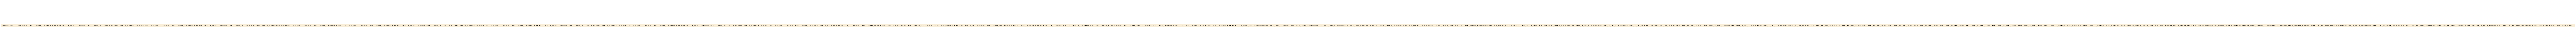

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 4))

# Add annotation with the long text
annotation_text = (
    "Probability = 1 / (1 + exp(-("
    "+0.1960 * COLOR_-16777216 + "
    "+0.2090 * COLOR_-16777215 + "
    "+0.2297 * COLOR_-16777214 + "
    "+0.1747 * COLOR_-16777213 + "
    "+0.1974 * COLOR_-16777211 + "
    "+0.1636 * COLOR_-16777209 + "
    "+0.1661 * COLOR_-16777208 + "
    "+0.1735 * COLOR_-16777207 + "
    "+0.1792 * COLOR_-16777206 + "
    "+0.1640 * COLOR_-16777205 + "
    "+0.1625 * COLOR_-16777204 + "
    "-0.0127 * COLOR_-16777203 + "
    "+0.1802 * COLOR_-16777202 + "
    "+0.1815 * COLOR_-16777201 + "
    "+0.1865 * COLOR_-16777200 + "
    "+0.1416 * COLOR_-16777199 + "
    "+0.1639 * COLOR_-16777198 + "
    "+0.1955 * COLOR_-16777197 + "
    "+0.1832 * COLOR_-16777196 + "
    "+0.2368 * COLOR_-16777195 + "
    "+0.1928 * COLOR_-16777193 + "
    "+0.2051 * COLOR_-16777192 + "
    "+0.1698 * COLOR_-16777190 + "
    "+0.1788 * COLOR_-16777189 + "
    "+0.2827 * COLOR_-16777188 + "
    "+0.2214 * COLOR_-16777187 + "
    "+0.2179 * COLOR_-16777186 + "
    "+0.0783 * COLOR_0 + "
    "-0.2138 * COLOR_255 + "
    "+0.1366 * COLOR_32768 + "
    "+0.2609 * COLOR_32896 + "
    "-0.2319 * COLOR_65280 + "
    "-0.4825 * COLOR_65535 + "
    "+0.1297 * COLOR_8388736 + "
    "+0.0842 * COLOR_8421376 + "
    "+0.1584 * COLOR_8421504 + "
    "+0.1667 * COLOR_10789024 + "
    "+0.1776 * COLOR_12632256 + "
    "-0.0317 * COLOR_12639424 + "
    "+0.1698 * COLOR_15780518 + "
    "+0.1820 * COLOR_15793151 + "
    "+0.2557 * COLOR_16711680 + "
    "-0.2172 * COLOR_16711935 + "
    "-0.1498 * COLOR_16776960 + "
    "+0.1256 * SICK_FUND_חברת ביטוח + "
    "+0.0460 * SICK_FUND_כללית + "
    "-0.1369 * SICK_FUND_לאומית + "
    "+0.0171 * SICK_FUND_מכבי + "
    "+0.0570 * SICK_FUND_משרד בטחון + "
    "+0.0837 * AGE_GROUP_0-18 + "
    "+0.0795 * AGE_GROUP_19-30 + "
    "+0.0933 * AGE_GROUP_31-45 + "
    "-0.0011 * AGE_GROUP_46-60 + "
    "+0.0309 * AGE_GROUP_61-75 + "
    "-0.1992 * AGE_GROUP_76-90 + "
    "-0.0604 * AGE_GROUP_90+ + "
    "-0.0200 * PART_OF_DAY_03 + "
    "+0.0208 * PART_OF_DAY_07 + "
    "-0.1086 * PART_OF_DAY_08 + "
    "+0.0508 * PART_OF_DAY_09 + "
    "+0.0762 * PART_OF_DAY_10 + "
    "+0.1014 * PART_OF_DAY_11 + "
    "+0.0909 * PART_OF_DAY_12 + "
    "+0.1048 * PART_OF_DAY_13 + "
    "+0.1189 * PART_OF_DAY_14 + "
    "+0.0332 * PART_OF_DAY_15 + "
    "-0.1058 * PART_OF_DAY_16 + "
    "-0.1575 * PART_OF_DAY_17 + "
    "-0.2815 * PART_OF_DAY_18 + "
    "-0.0667 * PART_OF_DAY_19 + "
    "-0.0740 * PART_OF_DAY_20 + "
    "-0.0483 * PART_OF_DAY_21 + "
    "-0.0348 * PART_OF_DAY_22 + "
    "-0.0397 * PART_OF_DAY_23 + "
    "-0.0438 * meeting_length_interval_15-20 + "
    "+0.0831 * meeting_length_interval_20-30 + "
    "-0.0052 * meeting_length_interval_30-40 + "
    "-0.0428 * meeting_length_interval_40-50 + "
    "-0.0196 * meeting_length_interval_50-60 + "
    "-0.0666 * meeting_length_interval_< 15 + "
    "+0.0022 * meeting_length_interval_> 60 + "
    "-0.3247 * DAY_OF_WEEK_Friday + "
    "+0.0605 * DAY_OF_WEEK_Monday + "
    "-0.0346 * DAY_OF_WEEK_Saturday + "
    "+0.0868 * DAY_OF_WEEK_Sunday + "
    "-0.2612 * DAY_OF_WEEK_Thursday + "
    "-0.0398 * DAY_OF_WEEK_Tuesday + "
    "+0.1549 * DAY_OF_WEEK_Wednesday + "
    "-0.1310 * GENDER + "
    "+0.1682 * SMS_SERVICE)"
)

# Add annotation to the plot
ax.annotate(
    annotation_text,
    xy=(0.5, 0.5), 
    xycoords='axes fraction',
    fontsize=8,
    ha='center',
    va='center',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# Hide the axes
ax.axis('off')

# Display the plot
plt.show()


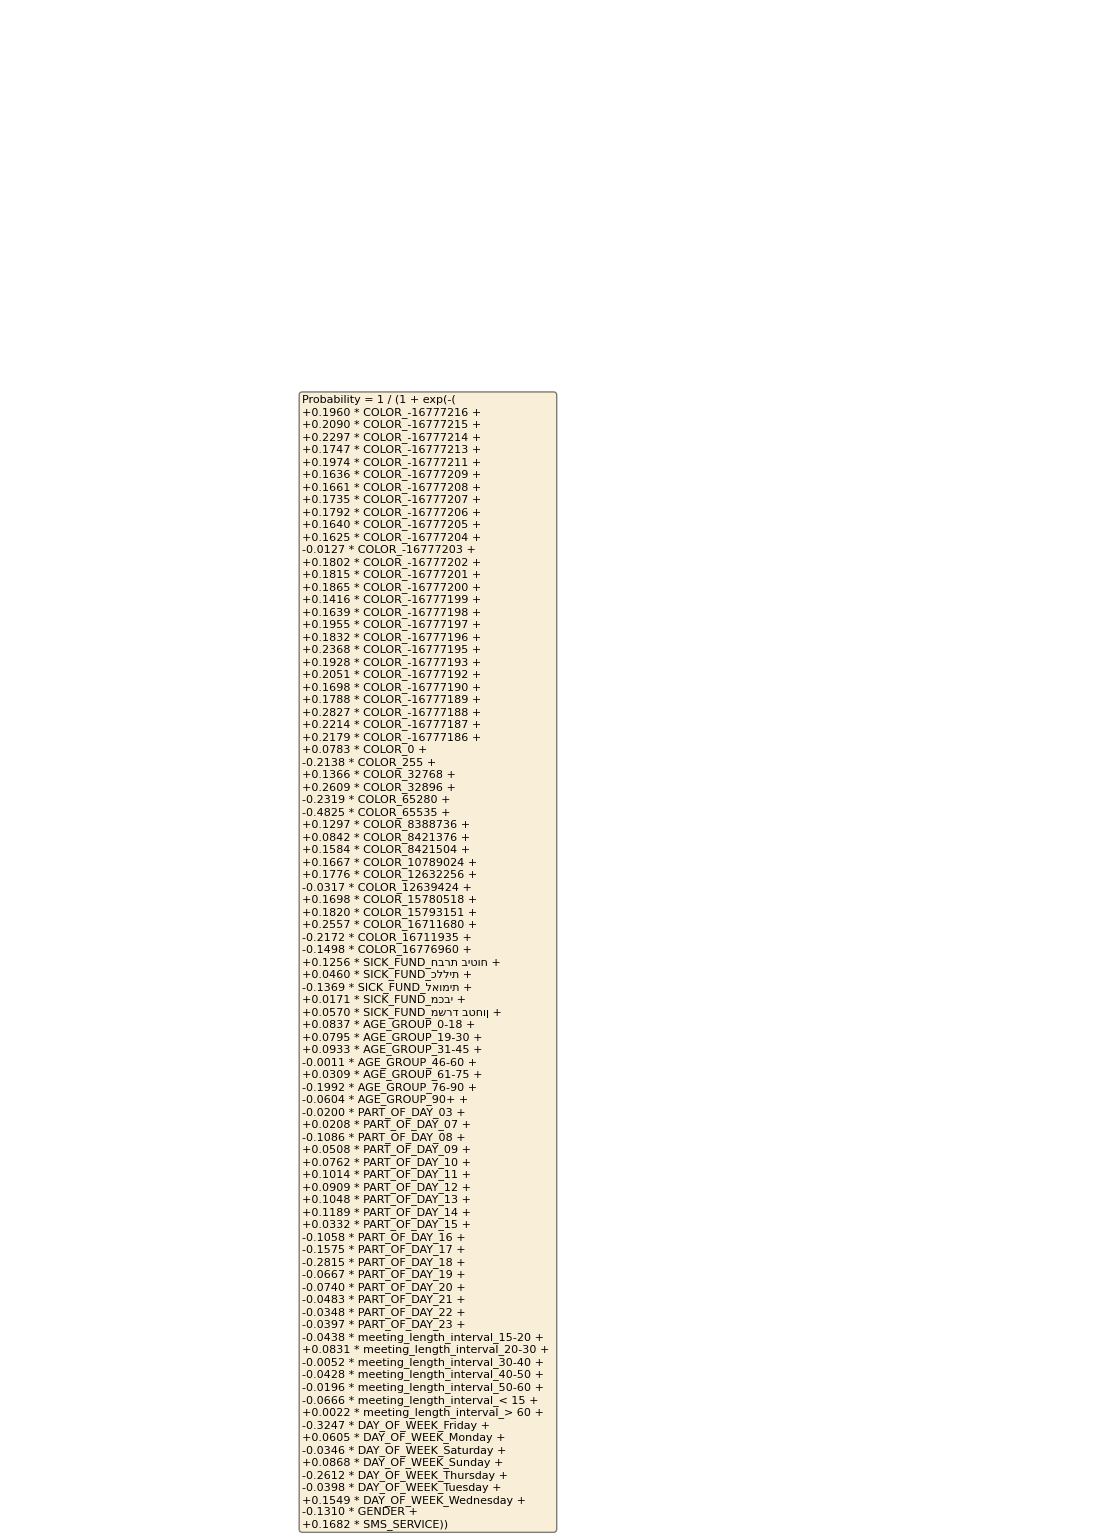

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))  # Increased height for better readability

# Add annotation with the long text
annotation_text = (
    "Probability = 1 / (1 + exp(-(\n"
    "+0.1960 * COLOR_-16777216 + \n"
    "+0.2090 * COLOR_-16777215 + \n"
    "+0.2297 * COLOR_-16777214 + \n"
    "+0.1747 * COLOR_-16777213 + \n"
    "+0.1974 * COLOR_-16777211 + \n"
    "+0.1636 * COLOR_-16777209 + \n"
    "+0.1661 * COLOR_-16777208 + \n"
    "+0.1735 * COLOR_-16777207 + \n"
    "+0.1792 * COLOR_-16777206 + \n"
    "+0.1640 * COLOR_-16777205 + \n"
    "+0.1625 * COLOR_-16777204 + \n"
    "-0.0127 * COLOR_-16777203 + \n"
    "+0.1802 * COLOR_-16777202 + \n"
    "+0.1815 * COLOR_-16777201 + \n"
    "+0.1865 * COLOR_-16777200 + \n"
    "+0.1416 * COLOR_-16777199 + \n"
    "+0.1639 * COLOR_-16777198 + \n"
    "+0.1955 * COLOR_-16777197 + \n"
    "+0.1832 * COLOR_-16777196 + \n"
    "+0.2368 * COLOR_-16777195 + \n"
    "+0.1928 * COLOR_-16777193 + \n"
    "+0.2051 * COLOR_-16777192 + \n"
    "+0.1698 * COLOR_-16777190 + \n"
    "+0.1788 * COLOR_-16777189 + \n"
    "+0.2827 * COLOR_-16777188 + \n"
    "+0.2214 * COLOR_-16777187 + \n"
    "+0.2179 * COLOR_-16777186 + \n"
    "+0.0783 * COLOR_0 + \n"
    "-0.2138 * COLOR_255 + \n"
    "+0.1366 * COLOR_32768 + \n"
    "+0.2609 * COLOR_32896 + \n"
    "-0.2319 * COLOR_65280 + \n"
    "-0.4825 * COLOR_65535 + \n"
    "+0.1297 * COLOR_8388736 + \n"
    "+0.0842 * COLOR_8421376 + \n"
    "+0.1584 * COLOR_8421504 + \n"
    "+0.1667 * COLOR_10789024 + \n"
    "+0.1776 * COLOR_12632256 + \n"
    "-0.0317 * COLOR_12639424 + \n"
    "+0.1698 * COLOR_15780518 + \n"
    "+0.1820 * COLOR_15793151 + \n"
    "+0.2557 * COLOR_16711680 + \n"
    "-0.2172 * COLOR_16711935 + \n"
    "-0.1498 * COLOR_16776960 + \n"
    "+0.1256 * SICK_FUND_חברת ביטוח + \n"
    "+0.0460 * SICK_FUND_כללית + \n"
    "-0.1369 * SICK_FUND_לאומית + \n"
    "+0.0171 * SICK_FUND_מכבי + \n"
    "+0.0570 * SICK_FUND_משרד בטחון + \n"
    "+0.0837 * AGE_GROUP_0-18 + \n"
    "+0.0795 * AGE_GROUP_19-30 + \n"
    "+0.0933 * AGE_GROUP_31-45 + \n"
    "-0.0011 * AGE_GROUP_46-60 + \n"
    "+0.0309 * AGE_GROUP_61-75 + \n"
    "-0.1992 * AGE_GROUP_76-90 + \n"
    "-0.0604 * AGE_GROUP_90+ + \n"
    "-0.0200 * PART_OF_DAY_03 + \n"
    "+0.0208 * PART_OF_DAY_07 + \n"
    "-0.1086 * PART_OF_DAY_08 + \n"
    "+0.0508 * PART_OF_DAY_09 + \n"
    "+0.0762 * PART_OF_DAY_10 + \n"
    "+0.1014 * PART_OF_DAY_11 + \n"
    "+0.0909 * PART_OF_DAY_12 + \n"
    "+0.1048 * PART_OF_DAY_13 + \n"
    "+0.1189 * PART_OF_DAY_14 + \n"
    "+0.0332 * PART_OF_DAY_15 + \n"
    "-0.1058 * PART_OF_DAY_16 + \n"
    "-0.1575 * PART_OF_DAY_17 + \n"
    "-0.2815 * PART_OF_DAY_18 + \n"
    "-0.0667 * PART_OF_DAY_19 + \n"
    "-0.0740 * PART_OF_DAY_20 + \n"
    "-0.0483 * PART_OF_DAY_21 + \n"
    "-0.0348 * PART_OF_DAY_22 + \n"
    "-0.0397 * PART_OF_DAY_23 + \n"
    "-0.0438 * meeting_length_interval_15-20 + \n"
    "+0.0831 * meeting_length_interval_20-30 + \n"
    "-0.0052 * meeting_length_interval_30-40 + \n"
    "-0.0428 * meeting_length_interval_40-50 + \n"
    "-0.0196 * meeting_length_interval_50-60 + \n"
    "-0.0666 * meeting_length_interval_< 15 + \n"
    "+0.0022 * meeting_length_interval_> 60 + \n"
    "-0.3247 * DAY_OF_WEEK_Friday + \n"
    "+0.0605 * DAY_OF_WEEK_Monday + \n"
    "-0.0346 * DAY_OF_WEEK_Saturday + \n"
    "+0.0868 * DAY_OF_WEEK_Sunday + \n"
    "-0.2612 * DAY_OF_WEEK_Thursday + \n"
    "-0.0398 * DAY_OF_WEEK_Tuesday + \n"
    "+0.1549 * DAY_OF_WEEK_Wednesday + \n"
    "-0.1310 * GENDER + \n"
    "+0.1682 * SMS_SERVICE))"
)

# Add annotation to the plot
ax.annotate(
    annotation_text,
    xy=(0.5, 0.5), 
    xycoords='axes fraction',
    fontsize=8,
    ha='left',
    va='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
    xytext=(-180, 0),  # Adjust x and y position of the annotation
    textcoords='offset points'
)

# Hide the axes
ax.axis('off')

# Display the plot
plt.show()


# Code to Visualize Feature Importances

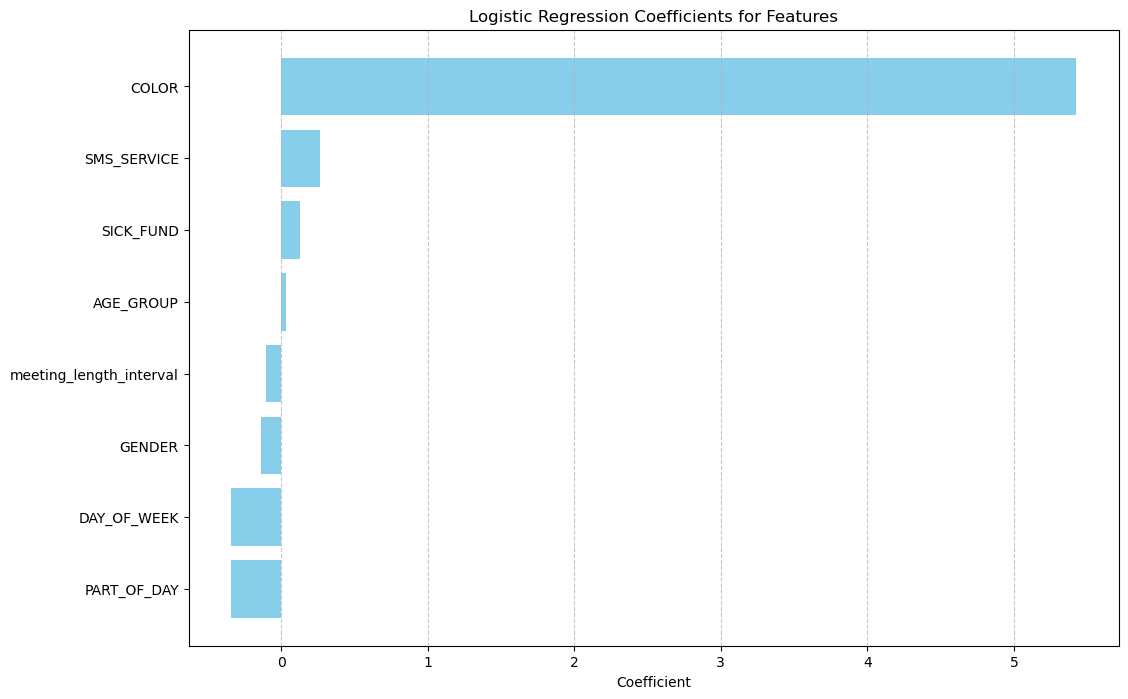

In [84]:
import matplotlib.pyplot as plt

# Aggregate the coefficients again for visualization
agg_feature_importance = pd.DataFrame.from_dict(aggregated_coefficients, orient='index', columns=['Coefficient'])
agg_feature_importance = agg_feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
def plot_coefficients(agg_feature_importance):
    plt.figure(figsize=(12, 8))
    plt.barh(agg_feature_importance.index, agg_feature_importance['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient')
    plt.title('Logistic Regression Coefficients for Features')
    plt.gca().invert_yaxis()  # Highest coefficients on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Call the plot function
plot_coefficients(agg_feature_importance)
